In [1]:
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg','pdf')

import csv
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'Times'
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['figure.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [2]:
dt = 3.6
dx = 2.2e-2

tf = 3*3600
xf = 6.1

t = np.arange(0, tf + dt, dt)
x = np.arange(0, xf + dx, dx)

dx = x[2] - x[1]

Nx = len(x) - 1
Nt = len(t) - 1

In [3]:
Tmin = 290 + 273
Tmax = 395 + 273
eps = 0.22

d = 0.015
u = 4.36e-4

In [4]:
CFL = dt*u/dx
CFL

0.07134545454545456

In [5]:
s0h = np.loadtxt('./Sandia_0h.csv', delimiter=";", dtype=float)
T0p = s0h[:,1] + 273
x0p = s0h[:,0]

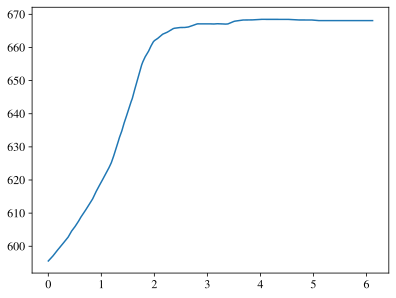

In [6]:
T0 = np.interp(x, x0p, T0p)

plt.plot(x, T0)
plt.show()

In [7]:
Tin = Tmin
# thetaIn = (Tin - Tmin)/(Tmax - Tmin)

Tf = np.zeros((Nt+1, Nx+1))
Ts = np.zeros((Nt+1, Nx+1))

# ICs
Tf[0,:] = T0
Ts[0,:] = T0

# BCs
Tf[:,0] = Tin

# Thetaf = (Tf - Tmin)/(Tmax - Tmin)
# Thetas = (Ts - Tmin)/(Tmax - Tmin)

In [8]:
Tavg = 0.5*(Tmax + Tmin)

rhof = 2090 - 0.636*Tavg
muf = (22.174 - 0.12*Tavg + 2.281e-4*Tavg**2 - 1.474e-7*Tavg**3)/1000
cpf = 1550 #1443 + 0.172*Tavg

eps = 0.22

rhos = 2500
cps = 830
# ks = 2.5 #5.69
# Lambda = 5.69

In [18]:
alpha = eps*rhof*cpf
beta = eps*(0.443 + 0.00019*Tavg)
gamma = (1-eps)*rhos*cps

dp = 19.1e-3
Rep = rhof*dp*u/muf
Pr = cpf*muf/beta
hv = 6*(1-eps)*beta*(2 + 1.1*Rep**(0.6)*Pr**(1/3))/(dp**2)

p = dt*u/dx
q = beta/alpha*0.5*dt/(dx**2)
r = hv*dt/alpha
s = dt*hv/gamma

In [19]:
diagonals = [np.ones(Nx)*(1 + 2*q), np.ones(Nx)*(-q), np.ones(Nx)*(-q)]
offsets = [0, 1, -1]
A = sp.sparse.diags(diagonals, offsets).toarray()
A[-1,-2] = -2*q

A = sp.sparse.csr_matrix(A)
A_inv = sp.sparse.linalg.inv(A)

In [20]:
diagonals = [np.ones(Nx)*(1  - p - 2*q - r), np.ones(Nx)*(q), np.ones(Nx)*(p + q)]
offsets = [0, 1, -1]
B = sp.sparse.diags(diagonals, offsets).toarray()
B[-1,-2] = p + 2*q

B = sp.sparse.csr_matrix(B)

In [21]:
bc0 = np.zeros(Nx)
bc1 = np.zeros(Nx)

bc0[0] = Tin
bc1[0] = Tin

In [22]:
for i in range(1,Nt+1):
    #
    # Para tener en cuenta la variacion de rho, cp, beta, etc. con el tiempo
    #
#     alpha = eps*rhof*cpf
#     beta = eps*(0.443 + 0.00019*Tavg)
#     gamma = (1-eps)*rhos*cps

#     dp = 19.1e-3
#     Rep = rhof*dp*u/muf
#     Pr = cpf*muf/beta
#     hv = 6*(1-eps)*beta*(2 + 1.1*Rep**(0.6)*Pr**(1/3))/(dp**2)

#     p = dt*u/dx
#     q = beta/alpha*0.5*dt/(dx**2)
#     r = hv*dt/alpha
#     s = dt*hv/gamma 
    
#     #
#     # Creacion de matrices de diferenciacion para cada instante
#     #
#     diagonals = [np.ones(Nx)*(1 + 2*q), np.ones(Nx)*(-q), np.ones(Nx)*(-q)]
#     offsets = [0, 1, -1]
#     A = sp.sparse.diags(diagonals, offsets).toarray()
#     A[-1,-2] = -2*q

#     A = sp.sparse.csr_matrix(A)
#     A_inv = sp.sparse.linalg.inv(A) 

#     diagonals = [np.ones(Nx)*(1  - p - 2*q - r), np.ones(Nx)*(q), np.ones(Nx)*(p + q)]
#     offsets = [0, 1, -1]
#     B = sp.sparse.diags(diagonals, offsets).toarray()
#     B[-1,-2] = p + 2*q

#     B = sp.sparse.csr_matrix(B)
    
    #
    # Solucion del sistema de PDEs
    #
    
    Tf[i,1:] = A_inv.dot(B.dot(Tf[i-1,1:]) + q*bc1 + (p + q)*bc0 +\
               r*Ts[i-1,1:])
    
    Ts[i,1:] = s*(Tf[i-1,1:] - Ts[i-1,1:]) + Tf[i-1,1:]    
    
    # Update solid BCs
    #
    Ts[i,0] = Ts[i,1]
    Ts[i,-1] = Ts[i,-2]

#     Thetaf[i,1:] = A_inv.dot(B.dot(Thetaf[i-1,1:]) + (q)*bc1 + (p + q)*bc0 +\
#                r*Thetas[i-1,1:])
    
#     Thetas[i,1:] = s*(Thetaf[i-1,1:] - Thetas[i-1,1:]) + Thetaf[i-1,1:]    
    
#     # Update solid BCs
#     #
#     Thetas[i,0] = Thetas[i,1]
#     Thetas[i,-1] = Thetas[i,-2]

In [23]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(8,8), sharex='row')
(ax1, ax2) = axs

cs1 = ax1.contourf(x, t/3600, Tf - 273, 16)
plt.tight_layout()
cbar1 = plt.colorbar(cs1)
cbar1.set_label(r'$T_f$ ($^\circ$ C)', fontsize=16)
ax1.set_ylabel(r'$t$ (h)')
ax1.set_box_aspect(1)
# ax1.set_xlim([0, 6])

cs2 = ax2.contourf(x, t/3600, Ts - 273, 16)
cbar2 = plt.colorbar(cs2)
cbar2.set_label(r'$T_s$ ($^\circ$ C)', fontsize=16)
ax2.set_xlabel(r'$y$ (m)')
ax2.set_ylabel(r'$t$ (h)')
ax2.set_box_aspect(1)
# ax2.set_xlim([0, 6])


# plt.colorbar()
# plt.xlim([0, 0.05])
# plt.ylim([0, 10])

plt.show()

In [15]:
nt0p5h = int(0.5*3600/dt)
nt1h = int(3600/dt)
nt1p5h = int(1.5*3600/dt)
nt2h = int(2*3600/dt)

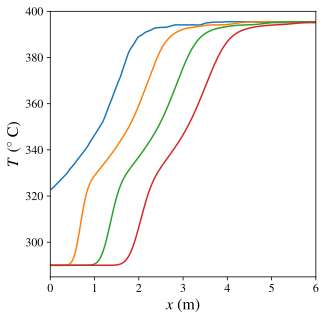

In [28]:
fig, ax = plt.subplots()
plt.plot(x[1:], Tf[0,1:] - 273, x, Tf[nt0p5h,:] - 273, x, Tf[nt1h,:] - 273, x, Tf[nt1p5h,:] - 273, x, Tf[-1,:])
plt.ylim([Tmin-5-273, Tmax+5-273])
plt.xlim([0, 6])
# plt.legend([r'0.0 h', r'0.5 h', r'1.0 h', r'1.5 h', r'2.0 h'])
ax.set_box_aspect(1)
ax.set_xlabel(r'$x$ (m)')
ax.set_ylabel(r'$T$ ($^\circ$ C)')
plt.show()

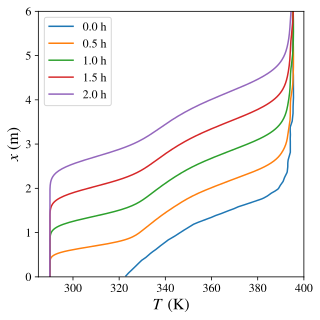

In [30]:
fig, ax = plt.subplots()
plt.plot(Tf[0,1:] - 273, x[1:], Tf[nt0p5h,:] - 273, x, Tf[nt1h,:] - 273, x, Tf[nt1p5h,:] - 273, x,  Tf[nt2h,:] - 273, x)
plt.xlim([Tmin-5-273, Tmax+5-273])
plt.ylim([0, 6])
plt.legend([r'0.0 h', r'0.5 h', r'1.0 h', r'1.5 h', r'2.0 h'])
ax.set_box_aspect(1)
ax.set_ylabel(r'$x$ (m)')
ax.set_xlabel(r'$T$ (K)')
plt.show()